# **Module 3:** Supervised Machine Learning Project

Colin Beyers\
GEOL558

# Project Overview

**Title**: Wave Height Prediction Using Machine Learning

Accurate prediction of **significant wave height ($H_s$)** is crucial for maritime safety, offshore operations, and coastal management. Traditional wave forecasting relies on numerical models that can be computationally expensive and may not fully capture localized variations. In this project, I will develop a machine learning (ML) model to predict $H_s$ based on observed wave parameters from the Coastal Data Information Program (CDIP). CDIP provides high-resolution, real-time buoy data, making it an ideal dataset for training an ML model to recognize complex relationships between wave frequency, period, direction, and energy density. By leveraging supervised learning, I aim to create a fast and accurate predictive model that can complement traditional forecasting methods, enhancing real-time decision-making for marine applications.

## Imports

In [233]:
#!pip install cartopy

In [20]:
# data handling
import pandas as pd

# plotting 
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature

# Data Acquisition and Preprocessing

To access CDIP buoy data, anyone can go to https://cdip.ucsd.edu/m/stn_table/ and pick your buoy of interest. Sometimes, buoys are "redeployed", so if you're interested in older data from before the most recent deployment, click on "Previous Deployments" in the "Station Details" box. To access the data, scroll down and click on "THREDDS Server". This page provides several ways to download data. The most straightforward way is to use "Netcdf Subset", which allows users to download data through a web interface.

For this project, I downloaded data from buoy 222: Santa Lucia Escarpment, which is in the California current system region. I downloaded about a year of data from 2023 to 2024. I downloaded the data as a CSV file so that I don't have to do as much preprocessing. I did not download any spectral data; just wave parameters and any necessary auxiliary information. For now, I will just consider this station while I build intuition about the project. Later, I will consider adding more stations.

## Data Preprocessing

In [21]:
url_2023 = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_3/cdip222-wave_params-2023.csv'
url_2024 = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_3/cdip222-wave_params-2024.csv'

df_2023 = pd.read_csv(url_2023)
df_2024 = pd.read_csv(url_2024)

df = pd.concat([df_2023, df_2024], ignore_index=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17569 entries, 0 to 17568
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   time                                      17569 non-null  object 
 1   station                                   17569 non-null  object 
 2   latitude[unit="degrees_north"]            17569 non-null  float64
 3   longitude[unit="degrees_east"]            17569 non-null  float64
 4   waveCheckFactor                           17569 non-null  object 
 5   waveDp[unit="degreeT"]                    17569 non-null  float64
 6   waveEnergyDensity[unit="meter^2 second"]  17569 non-null  object 
 7   waveFlagPrimary                           17569 non-null  int64  
 8   waveFlagSecondary                         17569 non-null  int64  
 9   waveHs[unit="meter"]                      17569 non-null  float64
 10  waveSourceIndex                   

In [23]:
df.describe()

,"latitude[unit=""degrees_north""]","longitude[unit=""degrees_east""]","waveDp[unit=""degreeT""]",waveFlagPrimary,waveFlagSecondary,"waveHs[unit=""meter""]",waveSourceIndex,"waveTa[unit=""second""]","waveTp[unit=""second""]","waveTz[unit=""second""]"
count,1.756900e+04,1.756900e+04,17569.000000,17569.0,17569.0,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000
mean,3.476600e+01,-1.214960e+02,286.227715,1.0,0.0,2.322396,8795.000000,8.014825,12.069376,7.004003
std,5.180004e-12,2.714350e-11,44.605915,0.0,0.0,0.894384,5071.877775,1.877503,3.304995,1.636348
min,3.476600e+01,-1.214960e+02,125.906250,1.0,0.0,0.730000,11.000000,4.497145,4.166667,4.000000
25%,3.476600e+01,-1.214960e+02,283.406250,1.0,0.0,1.670000,4403.000000,6.535653,9.876543,5.714286
50%,3.476600e+01,-1.214960e+02,300.281250,1.0,0.0,2.170000,8795.000000,7.800250,12.500000,6.666666
75%,3.476600e+01,-1.214960e+02,314.343750,1.0,0.0,2.780000,13187.000000,9.088266,14.285714,7.843137
max,3.476600e+01,-1.214960e+02,345.281250,1.0,0.0,8.120000,17579.000000,16.874348,22.222221,14.814815


The `dataframe` column titles can be switched up to help them be more interpretable.

In [24]:
df.rename(columns={
    "time": "time",
    "station": "station_id",
    "latitude[unit=\"degrees_north\"]": "latitude",
    "longitude[unit=\"degrees_east\"]": "longitude",
    "waveCheckFactor": "check_factor",
    "waveDp[unit=\"degreeT\"]": "peak_direction",
    "waveEnergyDensity[unit=\"meter^2 second\"]": "energy_density",
    "waveFlagPrimary": "flag_primary",
    "waveFlagSecondary": "flag_secondary",
    "waveHs[unit=\"meter\"]": "significant_wave_height",
    "waveSourceIndex": "source_index",
    "waveSpread[unit=\"degree\"]": "wave_spread",
    "waveTa[unit=\"second\"]": "average_period",
    "waveTp[unit=\"second\"]": "peak_period",
    "waveTz[unit=\"second\"]": "zero_crossing_period"
}, inplace=True)

Below is a description of each column:

- **timestamp**: The time of observation in ISO 8601 format (UTC).  
- **station_id**: The identifier for the buoy or station collecting the data.  
- **latitude**: The latitude of the station in degrees north.  
- **longitude**: The longitude of the station in degrees east.  
- **check_factor**: A quality control factor indicating the reliability of the wave data.  
- **peak_direction** (*degreeT*): The direction from which the most energetic waves are coming, measured in degrees true north.  
- **energy_density** (*m²·s*): The spectral wave energy density, representing the distribution of wave energy over frequency.  
- **flag_primary**: A primary quality flag for wave data validity.  
- **flag_secondary**: A secondary quality flag for additional data validation.  
- **significant_wave_height** (*m*): The average height of the highest one-third of waves in a given period.  
- **source_index**: The index identifying the source of the wave data.  
- **wave_spread** (*degree*): The directional spreading of wave energy, indicating how waves are distributed across directions.  
- **average_period** (*s*): The average wave period, calculated from the energy spectrum.  
- **peak_period** (*s*): The wave period corresponding to the most energetic waves in the spectrum.  
- **zero_crossing_period** (*s*): The average time interval between successive wave crests crossing the mean water level.

A few features were downloaded automatically, and are not necessary for this project.

In [25]:
df.drop(columns=['source_index', 'check_factor'], inplace=True)

Finally, we need to parse the `time` column to `datetime` object for easier plotting and handling.

In [26]:
df['time'] = pd.to_datetime(df['time'])
print(df['time'].head(10))

0   2023-06-15 00:00:00+00:00
1   2023-06-15 00:30:00+00:00
2   2023-06-15 01:00:00+00:00
3   2023-06-15 01:30:00+00:00
4   2023-06-15 02:00:00+00:00
5   2023-06-15 02:30:00+00:00
6   2023-06-15 03:00:00+00:00
7   2023-06-15 03:30:00+00:00
8   2023-06-15 04:00:00+00:00
9   2023-06-15 04:30:00+00:00
Name: time, dtype: datetime64[ns, UTC]


# Exploratory Data Analysis

## Data Quality

The primary data quality flag will give us an idea if there are any data that are suspicious.

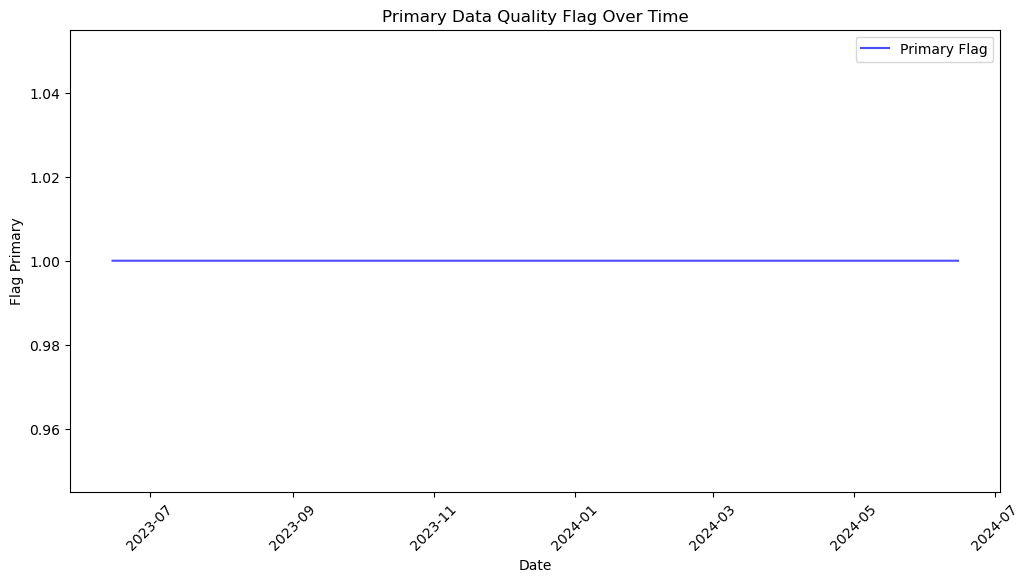

In [27]:
pyp.figure(figsize=(12, 6))
pyp.plot(df['time'], df['flag_primary'], label='Primary Flag', color='b', linestyle='-', alpha=0.7)
pyp.title('Primary Data Quality Flag Over Time')
pyp.xlabel('Date')
pyp.ylabel('Flag Primary')
pyp.xticks(rotation=45)
pyp.legend()
pyp.show()

All the data has a quality of 1, which is "good".

## Station Location

The station is location off the coast of California.

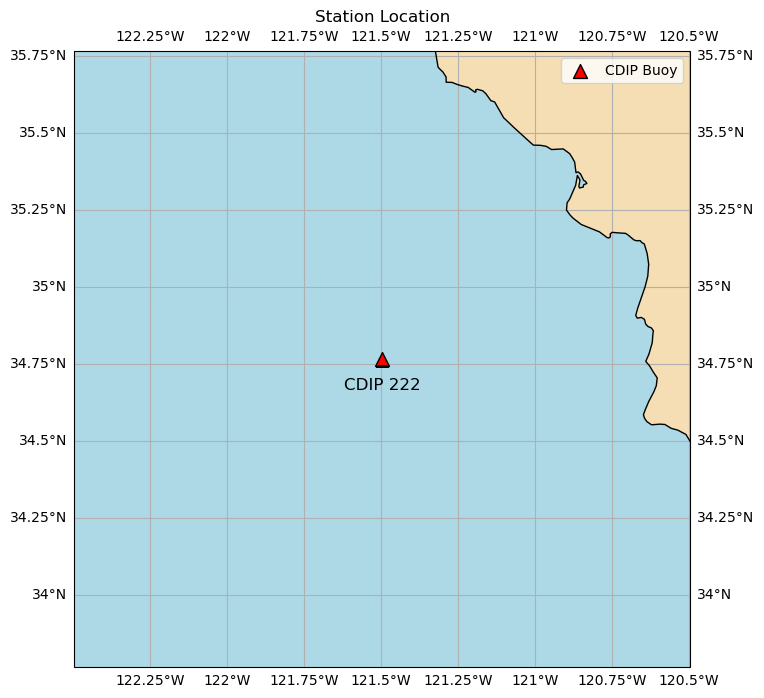

In [28]:
# extract lat/lon
lat = df['latitude'].iloc[0]
lon = df['longitude'].iloc[0]

fig, ax = pyp.subplots(figsize=(8, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon-1, lon+1, lat-1, lat+1])

# features
ax.coastlines(resolution='10m', color='black')
ax.gridlines(draw_labels=True, zorder = 1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='wheat')

# buoy location
ax.scatter(lon, lat, 
           color='red', marker='^', edgecolor='black', 
           s=100, label='CDIP Buoy', zorder=2)
ax.text(lon, lat-0.1, 'CDIP 222', ha='center', fontsize=12, color='black')

# title
ax.set_title('Station Location')
ax.legend(loc='upper right')

pyp.show()

## Correlation Heat Map

The main features I will be considering are the peak period, average crossing period, the 0th crossing period, and the peak direction. These features will be used to try and predict the significant wave height.

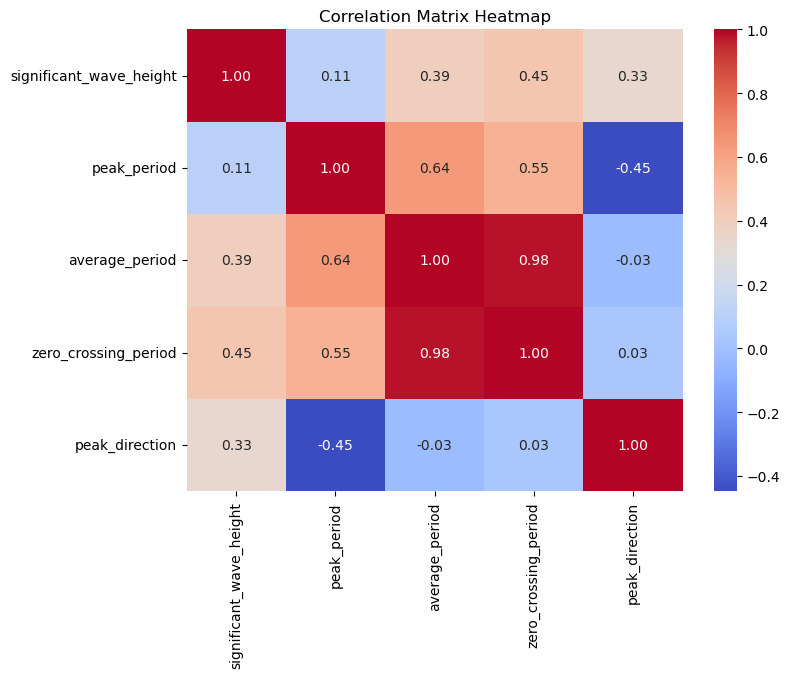

In [29]:
corr_matrix = df[['significant_wave_height', 
                  'peak_period', 
                  'average_period', 
                  'zero_crossing_period', 
                  'peak_direction']].corr()

# Plot the heatmap
pyp.figure(figsize=(8, 6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
pyp.title('Correlation Matrix Heatmap')
pyp.show()

The heatmap shows a near-perfect correlation between the average and 0th crossing periods. This is not surprising as these parameters are very closely related. Significant wave height is weakly negatively correlated with peak period (also associated with the peak wavelength). This means that significant wave height ($H_s$) does not depend much on the wavelength of the strongest waves at a the buoy. $H_s$ is more highly correlated with the 0th and average periods. These periods take into account all the different waves the buoy has measured in a 30 minute period, which may be the reason that $H_s$ is more correlated to them. This shows that there is some relationship between the wavelength of waves and their $H_s$. $H_s$ is somewhat correlated with the peak direction, indicating that waves coming more from the North have a higher chance at being larger.

In the future, I may decide to calculate more wave parameters from the spectral data if these parameters are not sufficient to calculate $H_s$. However, my goal is to try and avoid using spectral data at it would make the predictions easier to make.

## Pairplot

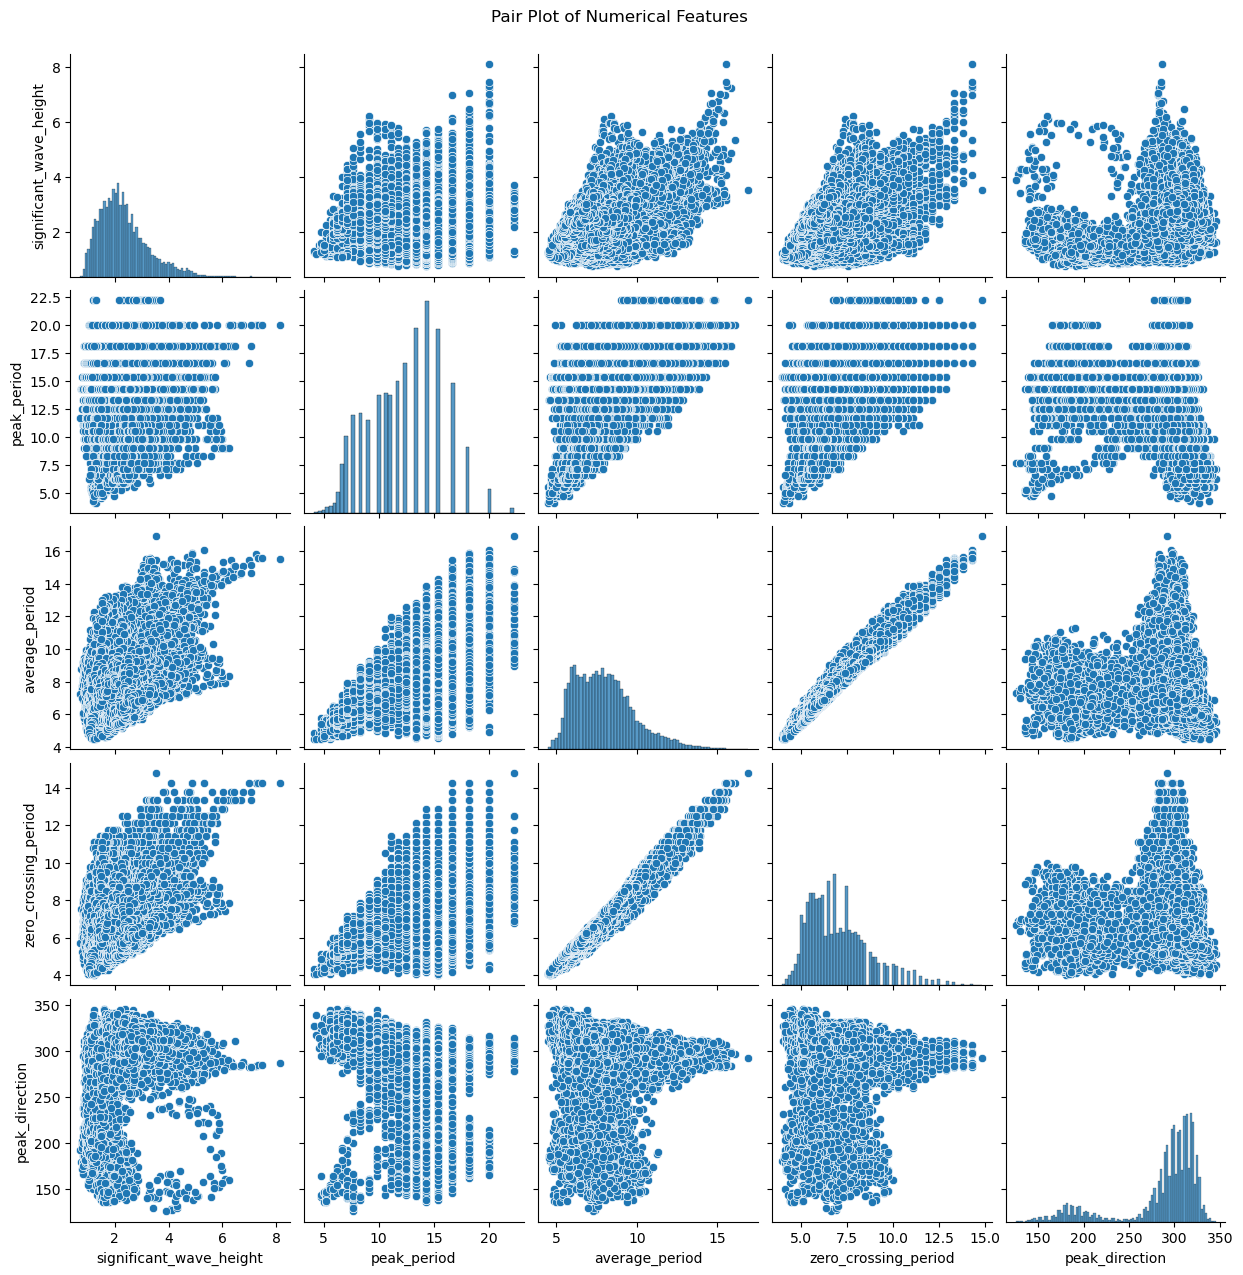

In [30]:
sbn.pairplot(df[['significant_wave_height', 
                 'peak_period', 
                 'average_period', 
                 'zero_crossing_period', 
                 'peak_direction']])
pyp.suptitle('Pair Plot of Numerical Features', y=1.02)
pyp.show()

This pairplot makes some further elaborations on what the correlation heat map showed us. First, note the strong linear relationship between the average and 0th periods. The pairplots between the features and $H_s$ don't look terribly promising; but the distribution of points doesn't necessarily look random. It's possible that an ML model will be able to find some relationships to predict $H_s$.

## Box and Whisker Plots

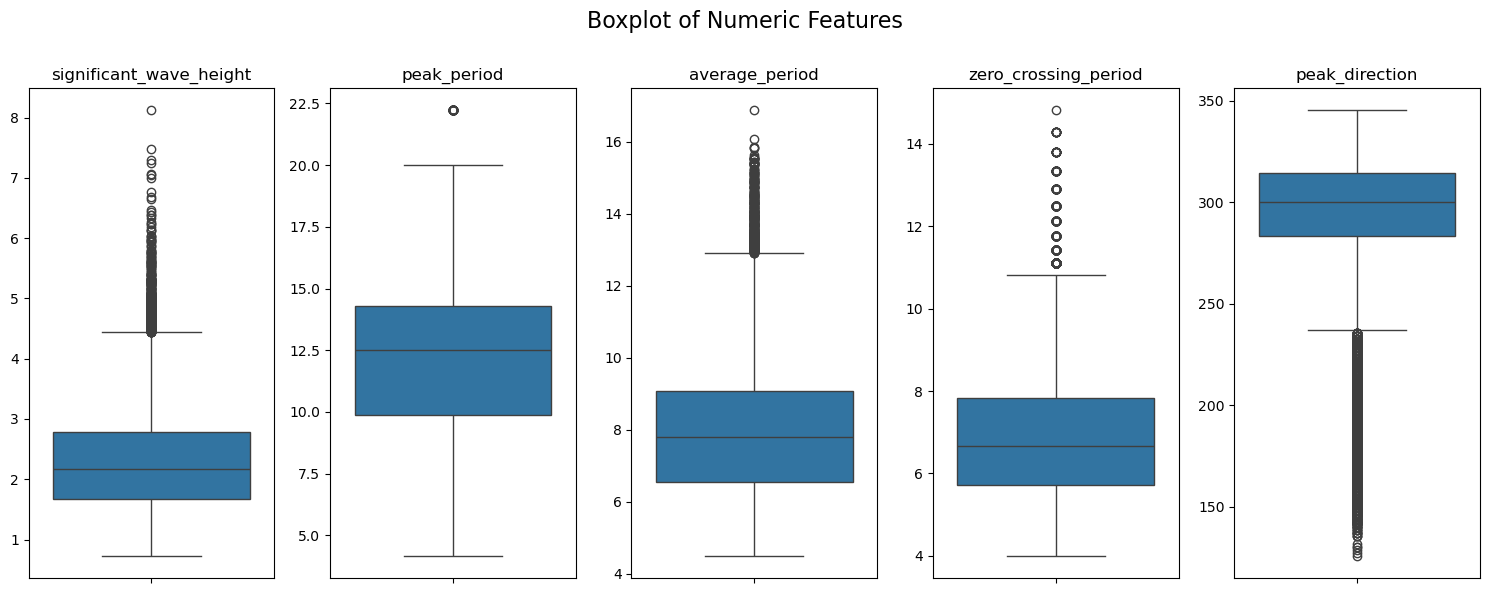

In [31]:
features = ['significant_wave_height', 
            'peak_period', 
            'average_period', 
            'zero_crossing_period', 
            'peak_direction']

fig, axes = pyp.subplots(nrows=1, ncols=len(features), figsize=(15, 6))

for ax, feature in zip(axes, features):
    sbn.boxplot(data=df[feature], ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Boxplot of Numeric Features', fontsize=16)

pyp.tight_layout()
pyp.subplots_adjust(top=0.85)

pyp.show()

Between 2023 and 2024, this buoy recorded relatively small $H_s$, but showed the potential to measure large $H_s$ (>7m). The peak period plot shows that many waves observed were ocean swell (long wavelength; period >10s). The peak period indicates where the energy maximum is in the spectrum, whereas the average and 0th crossing periods give more information about all the waves present. They show that on average, there was mostly locally generated wind waves (>10s) present. These box plots also show just how similar in range these two periods are. Based off of this, when training my ML model, I will exclude the 0th crossing period. THe peak direction shows that waves generally came from the N/NW.

## Time Series

The time series are smooth with a rolling average window of 1 day.

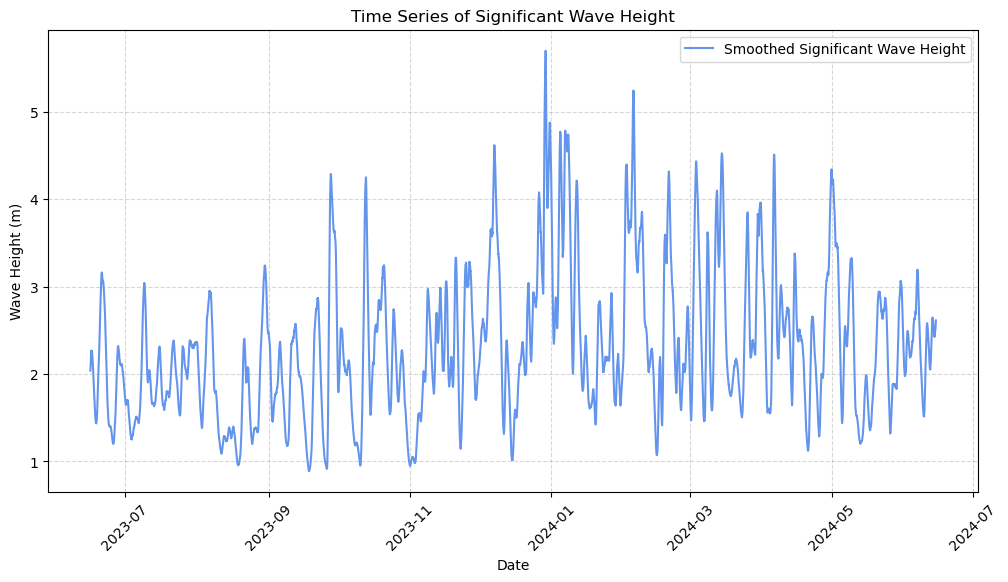

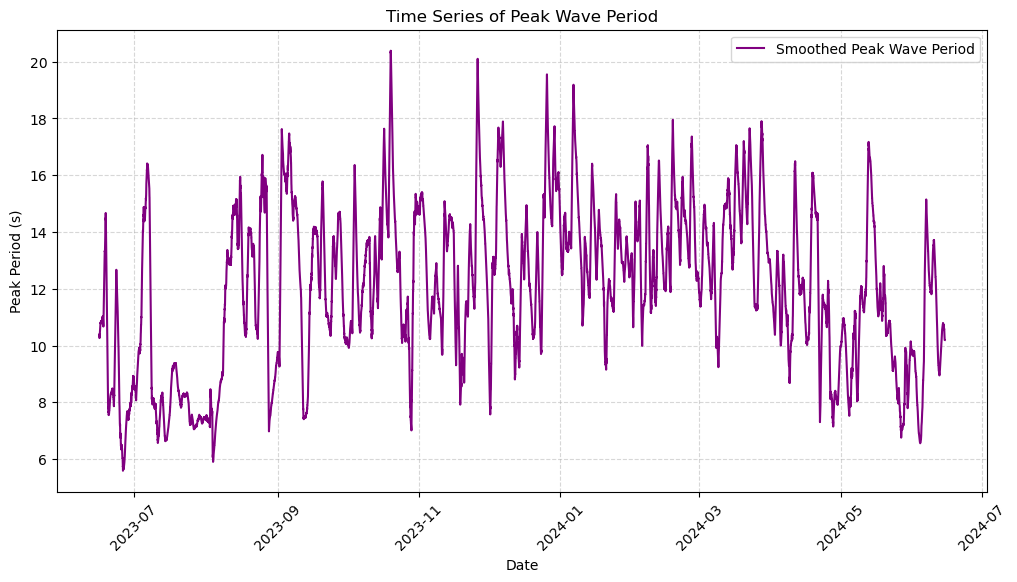

In [32]:
import matplotlib.pyplot as plt

# Rolling mean (window size of 7 for example, you can adjust this as needed)
df['smoothed_wave_height'] = df['significant_wave_height'].rolling(window=48).mean()
df['smoothed_peak_period'] = df['peak_period'].rolling(window=48).mean()

# Plot time series of significant wave height (smoothed)
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['smoothed_wave_height'], 
         color='cornflowerblue', label='Smoothed Significant Wave Height')
plt.title('Time Series of Significant Wave Height')
plt.xlabel('Date')
plt.ylabel('Wave Height (m)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Time series of peak period (smoothed)
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['smoothed_peak_period'], 
         color='purple', label='Smoothed Peak Wave Period')
plt.title('Time Series of Peak Wave Period')
plt.xlabel('Date')
plt.ylabel('Peak Period (s)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


Based off of this, it may also be wise to use the $H_s$ from the observation/hour/day prior to make the next prediction of $H_s$. I might try a combination of these values---I want to see how far in advance I can make predictions of $H_s$. The rationale behind this is that the time series of $H_s$ shows that it is somewhat cyclical; the next $H_s$ observation is based off the conditions before it.